<a href="https://colab.research.google.com/github/ianxdxd/housingEDA_Modeling/blob/main/housing_EDA_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install the Dataset and necessary libraries

In [ ]:
!pip install -q kaggle
from google.colab import files

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from scipy.special import boxcox1p
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [ ]:
! kaggle competitions download -c home-data-for-ml-course

  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 17.3MB/s]


In [ ]:
! unzip home-data-for-ml-course.zip

Archive:  home-data-for-ml-course.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.gz  
  inflating: test.csv                
  inflating: test.csv.gz             
  inflating: train.csv               
  inflating: train.csv.gz            


## EDA

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train.drop(['Id'], axis=1)

#### Quick Look

In [ ]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 80)


In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [ ]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Exploring the data

In [ ]:
numerical_trainCols = []
numerical_testCols = []
categorical_trainCols = []
categorical_testCols = []
for col in train.columns:
    if np.issubdtype(train[col].dtype, np.number):
        numerical_trainCols.append(col)
    else:
        categorical_trainCols.append(col)
for col in test.columns:
    if np.issubdtype(test[col].dtype, np.number):
        numerical_testCols.append(col)
    else:
        categorical_testCols.append(col)

In [ ]:
numerical_train = train.select_dtypes(include=[np.number])
corr_train = numerical_train.corr()
mask = np.triu(corr_train.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(corr_train,
            annot=True,
            fmt='.1f',
            cmap='viridis',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=True)

plt.show()

In [ ]:
def hist_numerical(data):
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = len(numerical_cols)
    n_rows = int(np.ceil(num_cols / 3))  # Change 3 to any number of columns per row
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        axes[i].hist(data[col].dropna(), bins=20, color='lightblue', edgecolor='black')
        axes[i].set_title(col)

    for j in range(i+1, len(axes)): # Hide any unused subplots
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

hist_numerical(train)

In [ ]:
def count_categorical(data):
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    num_cols = len(categorical_cols)
    n_rows = int(np.ceil(num_cols / 3))
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(data=data, x=col, hue=col, ax=axes[i], palette='Set2')
        axes[i].set_title(f'Count of {col}')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

count_categorical(train)

In [ ]:
# Numerical data against 'SalePrice'
def scatter_numerical(data, y_col='SalePrice'):
    numerical_cols = data.select_dtypes(include=[np.number]).columns.drop(y_col)
    num_cols = len(numerical_cols)
    n_rows = int(np.ceil(num_cols / 3))
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(numerical_cols):
        x = data[col].dropna()
        y = data[y_col].loc[x.index]
        axes[i].scatter(x, y, color='purple', edgecolor='black')
        axes[i].set_title(f'{col} vs {y_col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(y_col)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

scatter_numerical(train)

In [ ]:
def boxplot_categorical(data, y_col='SalePrice'):
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    num_cols = len(categorical_cols)
    n_rows = int(np.ceil(num_cols / 3))
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.boxplot(data=data, x=col, y=y_col, hue=col, ax=axes[i], palette='rocket')
        axes[i].set_title(f'{col} vs {y_col}')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

boxplot_categorical(train)

### Preparing the data

#### Dealing with missing values and outliers


Outliers are sensible to be deal with, you shouldn't always remove them. As we know outliers represent unusual values in our dataset, however in our case they might be *representing natural variations*.

In our case, we'll be removing outliers using the IQR method

In [ ]:
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] < 400000) & (train['LotArea'] < 100000)].index)
# def drop_outliers(df,num_features):
#     for col in num_features:
#         iqr = 1.5*(np.percentile(df[col], 75) - np.percentile(df[col], 25))
#         df.drop(df[df[col] > (iqr + np.percentile(df[col], 75))].index, inplace=True) # represents the largest value in the dataset
#         df.drop(df[df[col] < (np.percentile(df[col], 25) - iqr)].index, inplace=True) # represents the smallest value in the dataset

# numerical_cols_train = train.select_dtypes(include=np.number).columns
# drop_outliers(train, numerical_cols_train)

test_ID = test['Id'].reset_index(drop=True)
test = test.drop(['Id'], axis=1)

In [ ]:
y = train['SalePrice'].reset_index(drop=True)
train_ft = train.drop(['SalePrice'], axis=1)
train_features = train_ft.columns
test_features = test.columns
ft = pd.concat([train_ft, test]).reset_index(drop=True) # join dataset to make the manipulations easier

In [ ]:
dict_missingV = {}
for col in ft.columns:
    n_missing = ft[col].isnull().sum()
    if n_missing > 0:
        dict_missingV[col] = n_missing

numerical_missingCols = []
categorical_missingCols = []
for col in dict_missingV:
    if np.issubdtype(ft[col].dtype, np.number):
        numerical_missingCols.append(col)
    else:
        categorical_missingCols.append(col)

print(numerical_missingCols)
print(categorical_missingCols)

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']
['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

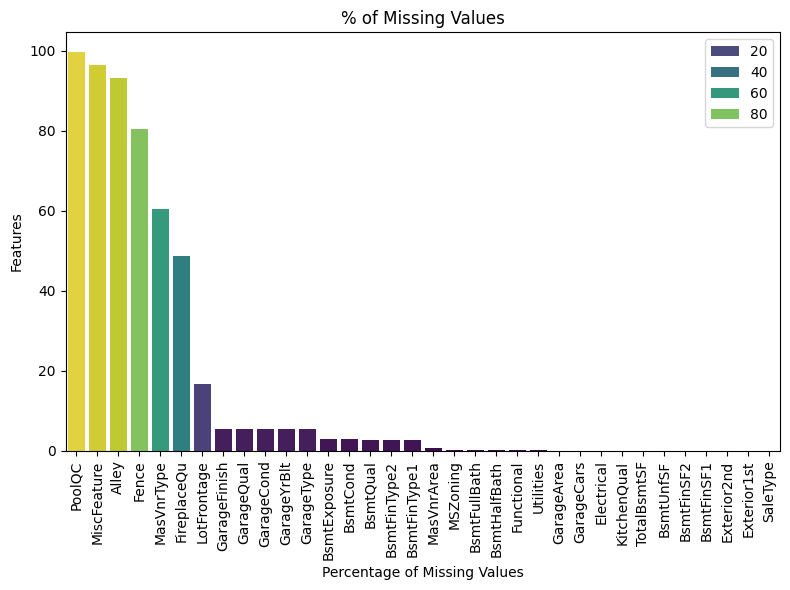

In [ ]:
missing_per100 = (ft.isnull().sum() / len(ft)) * 100
missing_per100 = missing_per100[missing_per100 > 0].sort_values(ascending=False)
fig = plt.figure(figsize=(8,6))
sns.barplot(x=missing_per100.index, y=missing_per100.values, hue=missing_per100.values, palette='viridis')
plt.title('% of Missing Values')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
fill_w_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType',
               'FireplaceQu', 'GarageFinish', 'GarageCond', 'GarageQual',
               'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1',
               'BsmtFinType2']
fill_w_0 = ['MasVnrArea', 'LotFrontage', 'BsmtUnfSF', 'GarageArea', 'GarageCars',
            'TotalBsmtSF','BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
            'BsmtHalfBath', 'GarageYrBlt']
fill_w_mode = ['MSZoning', 'Utilities', 'Electrical',
               'KitchenQual','Exterior2nd', 'Exterior1st', 'SaleType', 'Functional']

ft[fill_w_none] = ft[fill_w_none].fillna('NA')

ft[fill_w_0] = ft[fill_w_0].fillna(0)

for col in fill_w_mode:
    ft[col] = ft[col].fillna(ft[col].mode()[0])

ft['MSZoning'] = ft.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
ft['LotFrontage'] = ft.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
if ft.isnull().sum().all() == 0: print(True) # no missing values # Substituted all these steps in a pipeline

True


#### Feature Engineering

In [ ]:
ft['TotalHouseArea'] = (ft['1stFlrSF'] + ft['2ndFlrSF'] +
                           ft['BsmtFinSF1'] + ft['BsmtFinSF2'])
ft['TotalBathrooms'] = (ft['FullBath'] + (1/2)*ft['HalfBath'] +
                           ft['BsmtFullBath'] + (1/2)*ft['BsmtHalfBath'])
ft['TotalPorchArea'] = (ft['OpenPorchSF'] + ft['EnclosedPorch'] +
                           ft['ScreenPorch'] + ft['WoodDeckSF'] +
                           ft['3SsnPorch'])
ft['YrBltAndRemod'] = (ft['YearBuilt'] + ft['YearRemodAdd'])

In [ ]:
ft.shape

(2919, 83)

In [ ]:
# Some of the features would work best in the mdoel if converted
# to categorical features like mssubclass, overallcond, overallqual, mosold

condition_qual = ['Very Poor','Poor','Fair','Below Average', 'Average','Above Average',
                  'Good','Very Good','Excellent', 'Very Excellent']
mapping_cond = {i + 1: condition for i, condition in enumerate(condition_qual)}
ft['OverallCond'] = ft['OverallCond'].map(mapping_cond)
ft['OverallQual'] = ft['OverallQual'].map(mapping_cond)

month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
         'Nov', 'Dec']
mapping_mo = {i + 1: mo for i, mo in enumerate(month)}
ft['MoSold'] = ft['MoSold'].map(mapping_mo)

# ft['MSSubClass'] = ft['MSSubClass'].apply(str)

#### Box Cox Transformation

In [ ]:
# numerical_cols = ft.select_dtypes(include=np.number).columns
# skewed_features = ft[numerical_cols].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
# threshold = 0.75
# skewed_cols = skewed_features[abs(skewed_features) > threshold].index

In [ ]:
# for col in skewed_cols:
#     fig, ax = plt.subplots(1, 2, figsize=(12,4))
#     sns.histplot(ft[col], kde=True, color='red', ax=ax[0])
#     ax[0].set_title(f'{col} Distribution before Log Transformation')
#     stats.probplot(ft[col], plot=ax[1])
#     ax[1].set_title('Q-Q Plot before Log Transformation')
#     plt.tight_layout()
#     plt.show()

In [ ]:
# skewness = pd.Series(stats.skew(ft[numerical_cols]), index=numerical_cols).sort_values(ascending=False)
# moderate_high_skew = skewness[(skewness > 0.5)]
# skew_cols = moderate_high_skew.index
# for col in skewed_cols:
#     ft[col] = boxcox1p(ft[col], 0.15) # try other lambda values

In [ ]:
# for col in skewed_cols:
#     fig, ax = plt.subplots(1, 2, figsize=(12,4))
#     sns.histplot(ft[col], kde=True, color='red', ax=ax[0])
#     ax[0].set_title(f'{col} Distribution after Log Transformation')
#     stats.probplot(ft[col], plot=ax[1])
#     ax[1].set_title('Q-Q Plot after Log Transformation')
#     plt.tight_layout()
#     plt.show()

#### Log Transform ['SalePrice'] to reduce skewness

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(12,5))
# sns.histplot(y, kde=True, color='red', ax=ax[0])
# ax[0].set_title('SalePrice Distribution')
# stats.probplot(y, plot=ax[1])
# ax[1].set_title('Q-Q Plot')
# plt.tight_layout()
# plt.show()

As observed in the histogram, our target variable is not well-distributed, exhibiting right skewness. Furthermore, the Probability Plot confirms this skewness, as in a normal distribution, most points should align along the 45-degree reference line.

Given this, we can apply a log transformation to reduce the skewness of our target variable. In this process, each value
$x$ is transformed into $log(x)$ to make the data as close to normal as possible.

By applying the log transformation, we make the data more symmetric, stabilize the variance, and improve the performance of our regression model.

In [ ]:
y = np.log(y)

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(12,5))
# sns.histplot(y, kde=True, color='red', ax=ax[0])
# ax[0].set_title('SalePrice Distribution after Log Transformation')
# stats.probplot(y, plot=ax[1])
# ax[1].set_title('Q-Q Plot after Log Transformation')
# plt.tight_layout()
# plt.show()

In both plots, the effect of the transformation is evident. The histogram now shows a more bell-shaped distribution, and in the Q-Q plot, the data aligns more closely with the 45-degree reference line.

#### One-Hot and Ordinal Encoding

In [ ]:
categorical_cols = train.select_dtypes(include=['object', 'category']).columns
numerical_cols = train.select_dtypes(include=[np.number]).columns
print(categorical_cols)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [ ]:
# list_drop = ['MSSubClass','OverallCond','BsmtFinSF2','LowQualFinSF','BsmtHalfBath',
#                '3SsnPorch','YrSold','MoSold','MiscVal','PoolArea']

nominal_features = [
    'MSZoning', 'Street', 'Alley', 'LotConfig', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl','MasVnrType',
    'Foundation', 'Heating', 'Electrical', 'GarageType',
    'MiscFeature', 'SaleType', 'Utilities', 'CentralAir', 'Condition1', 'Condition2'
]
nominal_features.append('Neighborhood')
nominal_features.append('Exterior1st')
nominal_features.append('Exterior2nd')
# for col1 in nominal_features:
#     for col2 in list_drop:
#         if col1 != col2:
#             list_drop = list_drop
#         else:
#             nominal_features.remove(col1)
#             break

ordinal_features = [
    'LotShape', 'LandSlope','LandContour', 'ExterQual', 'OverallCond', 'OverallQual',
    'ExterCond', 'BsmtQual', 'BsmtCond','BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageFinish',
    'GarageQual', 'GarageCond','PavedDrive', 'PoolQC', 'Fence', 'SaleCondition', 'MoSold', 'Functional'
]
ordinal_features.append('MSSubClass')
# for col1 in ordinal_features:
#     for col2 in list_drop:
#         if col1 != col2:
#             list_drop = list_drop
#         else:
#             ordinal_features.remove(col1)
#             break

for col in nominal_features + ordinal_features:
    if (('None' in train[col].values)) != (('None' in test[col].values)):
        print(col) # all NaN values in the features were filled in both the training and the test set

In [ ]:
train = ft.iloc[:len(y), :]
test = ft.iloc[len(train):, :]
print(train.shape)
print(test.shape)

(1460, 83)
(1459, 83)


In [ ]:
categorical_features = nominal_features + ordinal_features

# Checking unique value counts for each categorical feature
for feature in categorical_features:
    unique_values = ft[feature].nunique()
    if unique_values >= 15:
        print(f'{feature}: {unique_values} unique values')

Neighborhood: 25 unique values
Exterior1st: 15 unique values
Exterior2nd: 16 unique values
MSSubClass: 16 unique values


In [ ]:
# high_cardinality_features = ['Neighborhood', 'Exterior1st', 'Exterior2nd','MSSubClass']
# target_encoder = TargetEncoder()
# train_hc = train[high_cardinality_features].copy()
# test_hc = test[high_cardinality_features].copy()
# train_TE = target_encoder.fit_transform(train_hc, y)
# test_TE = target_encoder.transform(test_hc)

In [ ]:
# ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# train_ordinal = train[ordinal_features].copy()
# test_ordinal = test[ordinal_features].copy()
# train_OE = ordinal_encoder.fit_transform(train_ordinal)
# test_OE = ordinal_encoder.transform(test_ordinal)

# train_encoded = pd.DataFrame(train_OE, columns=ordinal_features, index=train.index)
# test_encoded = pd.DataFrame(test_OE, columns=ordinal_features, index=test.index)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_nominal = train[nominal_features + ordinal_features]
test_nominal = test[nominal_features + ordinal_features]
train_OHE = ohe.fit_transform(train_nominal)
test_OHE = ohe.transform(test_nominal)

train_ohe_df = pd.DataFrame(train_OHE,
                            columns=ohe.get_feature_names_out(nominal_features + ordinal_features),
                            index=train.index)
test_ohe_df = pd.DataFrame(test_OHE,
                           columns=ohe.get_feature_names_out(nominal_features + ordinal_features),
                           index=test.index)

remaining_features = [col for col in train.columns if col not in nominal_features + ordinal_features]
train_final = pd.concat([train[remaining_features], train_ohe_df], axis=1)
test_final = pd.concat([test[remaining_features], test_ohe_df], axis=1)

train_final.reset_index(drop=True, inplace=True)
test_final.reset_index(drop=True, inplace=True)

In [ ]:
print('Train shape after encoding: ',train_final.shape)
print('Test shape after encoding',test_final.shape)

Train shape after encoding:  (1460, 348)
Test shape after encoding (1459, 348)


## Modeling

##### Applying Standard Scaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_final, y,
                                                    test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# train_scaled = scaler.fit_transform(train_final)
test_scaled = scaler.transform(test_final)

In [ ]:
def rmsle_cv_scores(model, X, y):
    k_folds = KFold(n_splits=10, random_state=42, shuffle=True)
    final_scores = cross_val_score(model, X, y,
                                   scoring="neg_mean_squared_error", cv=k_folds)
    final_rmse = np.sqrt(-final_scores)
    print("RMSE scores from cross-validation:", final_rmse)
    print("Mean RMSE:", final_rmse.mean())

##### Building the model

In [ ]:
base_models = [
    # ('xgb', xgb.XGBRegressor(subsample=0.8, n_estimators=800,
    #                          max_depth=3, learning_rate=0.01,
    #                          random_state=42)),
    ('gdb', GradientBoostingRegressor(subsample = 0.7, n_estimators=300,
                                      max_depth=4, learning_rate=0.05,
                                      random_state=42)),
    ('lgb', LGBMRegressor(objective='regression', n_estimators=100,
                          learning_rate=0.01, num_leaves=8, verbose=-1,
                          force_col_wise=True)),
    # ('knn', KNeighborsRegressor(weights='distance', p=2, n_neighbors=5)),
    # ('rfr', RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)),
    # ('krd', KernelRidge(alpha=1)),
    # ('lin', Ridge(alpha=30, random_state=9)),
    ('lin2', Lasso(alpha=0.001, random_state=42))
    # ('lin3', ElasticNet(l1_ratio=1, alpha=0.01, random_state=42)),
]
meta_model = Lasso(alpha=0.001, random_state=9)

model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
model.fit(X_train, y_train)

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('gdb',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=2,
                                                         n_estimators=300,
                                                         random_state=42)),
                              ('gdb2',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=1,
                                                         n_estimators=50,
                                                         random_state=42)),
                              ('lin', Ridge(alpha=30, random_state=9))],
                  final_estimator=Ridge(alpha=30, random_state=9))

In [ ]:
rmsle_cv_scores(model, X_train, y_train)

RMSE scores from cross-validation: [0.13950201 0.12807535 0.11014634 0.10918404 0.12353421 0.16777626
 0.1045333  0.1542379  0.1521654  0.13885947]
Mean RMSE: 0.13280143014886744


In [ ]:
rmsle_cv_scores(model, X_test, y_test)

##### Hyperparameter Tuning with RandomizedSearchCV

In [ ]:
param_grid = {
    'xgb__n_estimators' : [500,1000, 1500, 2000, 2500, 3000],
    'xgb__learning_rate' : [0.01,0.03,0.05,0.07,0.1],
    'xgb__max_depth' : [3,4,5,6,7],
    'xgb__subsample' : [0.5,0.6,0.7,0.8],
    'gdb__n_estimators' : [100,200,300, 400, 500, 1000],
    'gdb__max_depth' : [3,4,5],
    'gdb__learning_rate' : [0.01,0.03,0.05,0.1],
    'gdb__subsample' : [0.5,0.6,0.7,0.8],
    'lgb__n_estimators' : [100,200,300,400,500, 1000, 2000],
    'lgb__learning_rate' : [0.01,0.05,0.1],
    'lgb__num_leaves' : [3,4,5,6,7,8,9,10],
    # 'knn__n_neighbors' : [3,4,5,6,7,8,9,10],
    'lin2__alpha' : [0.001,0.05,0.1]
    # 'lin__l1_ratio' : [0.1,0.5,0.9]
}
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=StackingRegressor(estimators=[('xgb',
                                                            XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
                                                                         gamma=None,
                                                                         grow_policy=None,
                                                                         importance_type=None,
                                                                         intera...
                                        'lgb__learning_rate': [0.01, 0.05, 0.1],
                                        'lgb__n_estimators': [100, 200, 300,
                                                              400, 500, 1000,
                                                              2000],
                                        'lgb__num_leaves': [3, 4, 5, 6, 7, 8, 9,
                                                            10],
                                        'lin2__alpha': [0.001, 0.05, 0.1],
                                        'xgb__learning_rate': [0.01, 0.03, 0.05,
                                                               0.07, 0.1],
                                        'xgb__max_depth': [3, 4, 5, 6, 7],
                                        'xgb__n_estimators': [500, 1000, 1500,
                                                              2000, 2500,
                                                              3000],
                                        'xgb__subsample': [0.5, 0.6, 0.7, 0.8]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
rs_scores = random_search.cv_results_
for mean_score, params in zip(rs_scores['mean_test_score'], rs_scores['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
random_search.best_params_

## Submission

In [ ]:
y_pred = np.exp(model.predict(test_scaled))

In [ ]:
submission= pd.DataFrame({'Id': test_ID,'SalePrice': y_pred})

In [ ]:
submission.head()

,Id,SalePrice
0,1461,126451.600054
1,1462,148648.325247
2,1463,189295.130837
3,1464,195712.620772
4,1465,192397.630599


In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
! kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "54th sub"

100% 33.6k/33.6k [00:00<00:00, 63.7kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques